In [143]:
import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [144]:
daily_data = pd.read_csv('data/daily.csv')
govt_measures = pd.read_excel('data/acaps_covid19_government_measures_dataset.xlsx', sheet_name='Database')
daily_tests = pd.read_csv('data/full-list-covid-19-tests-per-day.csv')

In [145]:
daily_data.sort_values('date',inplace=True)

In [146]:
daily_tests.head()

,Entity,Code,Date,New tests
0,Argentina,ARG,"Feb 11, 2020",2
1,Argentina,ARG,"Feb 20, 2020",2
2,Argentina,ARG,"Feb 25, 2020",1
3,Argentina,ARG,"Feb 27, 2020",5
4,Argentina,ARG,"Feb 28, 2020",9


In [147]:
# Convert date to datetime object 
daily_data['date'] = pd.to_datetime(daily_data['date'], format='%Y%m%d')
daily_tests['Date'] = pd.to_datetime(daily_tests['Date'], format='%b %d, %Y')

In [148]:
# Filter only for United States
govt_measures = govt_measures[govt_measures['COUNTRY'] == 'United States of America']
daily_tests = daily_tests[daily_tests['Entity'] == 'United States']

In [149]:
#daily_data.merge(govt_measures, left_on='date', right_on='DATE_IMPLEMENTED', how='left')

In [150]:
daily_data = daily_data.merge(daily_tests, left_on='date', right_on='Date', how='left')

In [151]:
daily_data.columns

Index(['date', 'states', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'dateChecked', 'death', 'hospitalized', 'lastModified',
       'total', 'totalTestResults', 'posNeg', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease', 'hash', 'Entity', 'Code', 'Date',
       'New tests'],
      dtype='object')

In [152]:
feature_names = ['date','positive','totalTestResultsIncrease']
daily_data = daily_data[feature_names]

In [153]:
x = daily_data.copy()
x.index = x.date
x.drop('date',axis=1,inplace=True)

In [154]:
train = x[:int(0.8*(len(x)))]
valid = x[int(0.8*(len(x))):]

### Model 1 (VAR)

In [155]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [156]:
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [157]:
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,2):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
#for i in cols:
print('rmse value for Positive cases is : ', math.sqrt(mean_squared_error(pred['positive'], valid['positive'])))

rmse value for Positive cases is :  2406051.7536559775


In [158]:
model = VAR(endog=x)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=30)
print(yhat)

[[4160298.87673752  933769.4387666 ]
 [4228225.03916058  943718.56661761]
 [4296963.14637111  956490.76429587]
 [4366636.7943017   970654.04308099]
 [4437309.98274095  985567.54769548]
 [4509020.09077527 1000945.52808336]
 [4581792.67877185 1016661.64105213]
 [4655648.13375384 1032661.11709234]
 [4730604.65394474 1048921.33939708]
 [4806679.59028298 1065434.15131619]
 [4883890.05053936 1082197.91600222]
 [4962253.17250509 1099213.95305466]
 [5041786.24868207 1116484.939661  ]
 [5122506.78435544 1134014.19345269]
 [5204432.52579792 1151805.35110041]
 [5287581.47510086 1169862.22453242]
 [5371971.89903526 1188188.73688115]
 [5457622.33526645 1206788.89422048]
 [5544551.59741429 1225666.7733741 ]
 [5632778.7796292  1244826.51694411]
 [5722323.26098527 1264272.33158777]
 [5813204.70982621 1284008.4877597 ]
 [5905443.08812558 1304039.32011944]
 [5999058.65588938 1324369.22824547]
 [6094071.97561425 1345002.67749473]
 [6190503.91680756 1365944.19993549]
 [6288375.66057302 1387198.39532126]
 

/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [159]:
forecast = []
for i in yhat:
    forecast.append(i[0])

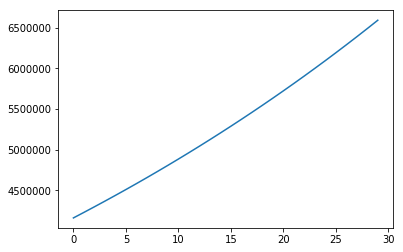

In [160]:
pd.Series(forecast).plot()

### Model 2 (ARIMAX)

In [161]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train.positive, exog=train.totalTestResultsIncrease, order=(1,1,1))
model_fit = model.fit()

/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [162]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.positive   No. Observations:                  147
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1331.383
Method:                       css-mle   S.D. of innovations           2052.785
Date:                Sun, 26 Jul 2020   AIC                           2672.766
Time:                        21:28:13   BIC                           2687.718
Sample:                    01-23-2020   HQIC                          2678.841
                         - 06-17-2020                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     6184.8158   8704.390      0.711      0.479   -1.09e+04    2.32e+04
totalTestResultsIncrease     0.0200      0.005      4.204      0.000       0.011       0.029
ar.L1.D.positive             0.9780      0.019     50.496      0.000       0.940       1.016
ma.L1.D.positive             0.0706      0.095      0.745      0.457      -0.115       0.256
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0225           +0.0000j            1.0225            0.0000
MA.1          -14.1617           +0.0000j           14.1617            0.5000
-----------------------------------------------------------------------------
"""